In [28]:
import logging
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout,Activation
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa as lr
import librosa.display
from glob import glob
import IPython
from IPython.display import Audio
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.io.wavfile as wav

In [29]:
gt_data = pd.read_csv(r"/Users/faizahpirzada/Downloads/Data/features_30_sec.csv")
print(gt_data.shape)
gt_data.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [30]:
# checking null values
gt_data[gt_data.isna()].value_counts().sum()

0

In [31]:
our_data = pd.read_csv(r"/Users/faizahpirzada/Downloads/top_50_songs_features.csv")
print(our_data.shape)
our_data.head()

(54, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.000000.wav,30000.000000,0.401282,0.086966,0.133645,0.009270,2285.466215,1.526304e+06,2458.856004,481152.227178,...,73.30818,-5.018557,75.411310,3.809938,43.845936,-8.759356,43.631207,-4.040365,59.195137,blues
1,blues.000001.wav,30000.000000,0.326063,0.102756,0.148318,0.031166,1207.054377,6.459471e+05,1481.555388,709502.398726,...,69.39578,-3.525022,42.324207,-1.874528,42.235626,-7.966536,44.953590,-4.028606,67.800440,blues
2,classical.00000.wav,30013.333333,0.252361,0.084149,0.036233,0.000221,1505.357460,4.443073e+04,1559.228895,43765.373123,...,86.13082,-0.318471,100.835740,1.773055,95.493810,0.888721,97.099720,-0.835078,120.920820,classical
3,country.00000.wav,30081.632653,0.383930,0.081185,0.248296,0.000716,2798.065627,3.546250e+05,2847.541181,105655.136749,...,68.59460,0.612088,54.308323,4.062127,74.348236,0.907919,68.547610,4.093193,73.602806,country
4,disco.000000.wav,30000.000000,0.383889,0.101591,0.127326,0.008411,2739.188163,1.498203e+06,2460.869989,333219.464706,...,63.21444,-10.986168,89.658240,-2.868585,70.230286,-13.567414,63.092510,-2.138512,76.132126,disco


In [32]:
# label encoding
gt_data['label'] = preprocessing.LabelEncoder().fit_transform(gt_data['label'])
our_data['label'] = preprocessing.LabelEncoder().fit_transform(our_data['label'])

In [33]:
# dividing the data into train and test sets
X_gt = gt_data.drop(['label', 'length','filename'], axis=1)
y_gt = gt_data['label']
X_50 = our_data.drop(['label', 'length','filename'], axis=1)
y_50 = our_data['label']

In [60]:
X_train = X_gt
y_train = y_gt
X_test = X_50
y_test = y_50

In [61]:
# scaling the features
transformer = preprocessing.MinMaxScaler()
X_train_trans = transformer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_trans, columns = X_train.columns)

X_test_trans = transformer.fit_transform(X_test)
X_test = pd.DataFrame(X_test_trans, columns = X_test.columns)

In [55]:
X_train.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,0.102567,...,0.564186,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255
1,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,0.342717,...,0.570198,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947
2,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,0.088981,...,0.622467,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405
3,0.473508,0.777954,0.345856,0.229160,0.129376,0.058253,0.267404,0.227566,0.181068,0.171001,...,0.565151,0.091876,0.484549,0.092509,0.460684,0.068975,0.538690,0.062612,0.468060,0.048168
4,0.277759,0.681062,0.219641,0.083075,0.327270,0.110761,0.325514,0.113536,0.357017,0.180228,...,0.383289,0.200462,0.410225,0.156424,0.403875,0.120300,0.424652,0.130173,0.233047,0.094836


In [56]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [57]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k

TF version:- 2.9.1


In [62]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=epochs,  
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [63]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               14848     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 10)                650       
                                                                 
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
8/8 [==============================] - 1s 35ms/step - loss: 2.2678 - accuracy: 0.1440 - val_loss: 2.1173 - val_accuracy: 0.3889
Epoch 2/70
8/8 [======================

Max. Validation Accuracy 0.40740740299224854


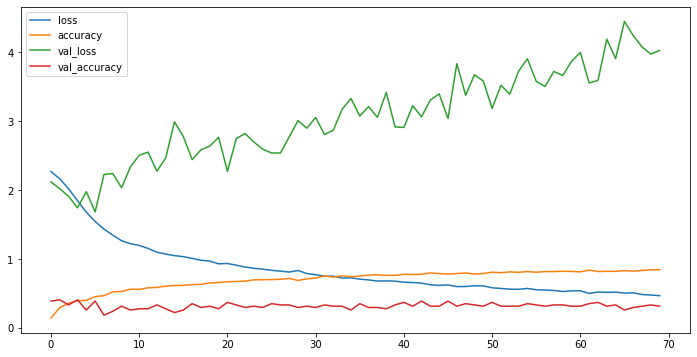

In [64]:
plotHistory(model_1_history)

In [65]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               29696     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)               

Max. Validation Accuracy 0.46296295523643494


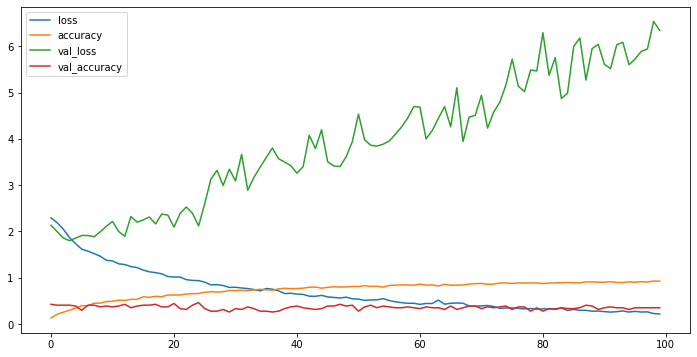

In [66]:
plotHistory(model_2_history)

In [67]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               29696     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)               

Max. Validation Accuracy 0.5185185074806213


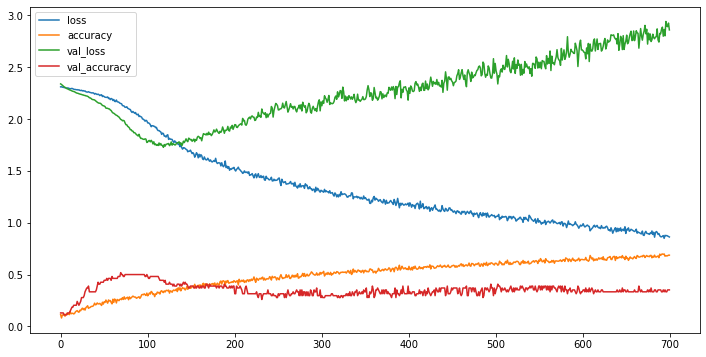

In [68]:
plotHistory(model_3_history)